In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
datapath = "../dataset/mimiciv/mit_pretrained"

# Preprocess Data

**Splitting**
- https://glassboxmedicine.com/2019/09/15/best-use-of-train-val-test-splits-with-tips-for-medical-data/

## Read Data

In [3]:
embs = pd.read_csv(f'{datapath}/cxr_ic_fusion_1103.csv', on_bad_lines='warn')

Skipping line 45052: expected 6405 fields, saw 7173
Skipping line 45053: expected 6405 fields, saw 7173



In [4]:
# # read line 45052 from a csv file
# with open('../dataset/mimiciv/mit_pretrained/cxr_ic_fusion_1103.csv', 'r') as f:
#     lines = f.read().splitlines()

In [5]:
# # write the erring lines to a new file
# with open('err_lines.txt', 'w') as f:
#     for line in lines[45050:45055]:
#         f.write(line + '\n\n')

In [6]:
len(embs), len(embs.columns)

(45050, 6405)

In [7]:
embs.split.unique()

array(['train', 'validate', 'test'], dtype=object)

In [8]:
embs.haim_id.nunique()

8655

## Split as Defined in Dataset

In [42]:
print("Number of samples in each split:")
print(f"train: {len(embs[embs.split == 'train']):,}")
print(f"val: {len(embs[embs.split == 'validate']):,}")
print(f"test: {len(embs[embs.split == 'test']):,}")

Number of samples in each split:
train: 43,738
val: 321
test: 991


In [43]:
print("Percentages of train, validate, test: ")
print(f"train: {len(embs[embs.split == 'train'])/len(embs)*100:.3f}%")
print(f"val: {len(embs[embs.split == 'validate'])/len(embs)*100:.3f}%")
print(f"test: {len(embs[embs.split == 'test'])/len(embs)*100:.3f}%")

Percentages of train, validate, test: 
train: 97.088%
val: 0.713%
test: 2.200%


### Columns

In [44]:
x_cols = [c for c in embs.columns if c.startswith(('haim_id', 'de_', 'vd', 'vmd', 'ts_ce', 'ts_le', 'ts_pe', 'n_ecg', 'n_ech', 'split'))]

In [45]:
# slice multiple groups of columns from embs
x = embs.loc[:, x_cols]
y = embs.loc[:, 'split': 'Pneumothorax']

In [46]:
len(x.columns), len(y.columns)

(4043, 14)

In [47]:
x.columns

Index(['haim_id', 'de_0', 'de_1', 'de_2', 'de_3', 'de_4', 'de_5', 'vd_0',
       'vd_1', 'vd_2',
       ...
       'n_ech_759', 'n_ech_760', 'n_ech_761', 'n_ech_762', 'n_ech_763',
       'n_ech_764', 'n_ech_765', 'n_ech_766', 'n_ech_767', 'split'],
      dtype='object', length=4043)

In [48]:
y.columns

Index(['split', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
       'Pneumothorax'],
      dtype='object')

### Split

In [49]:
# x_train = all rows where split == 'train' and all columns except 'split'
x_train = x.loc[x.split == 'train', x.columns != 'split']
y_train = y.loc[x.split == 'train', y.columns != 'split']

x_val = x.loc[x.split == 'validate', x.columns != 'split']
y_val = y.loc[x.split == 'validate', y.columns != 'split']

x_test = x.loc[x.split == 'test', x.columns != 'split']
y_test = y.loc[x.split == 'test', y.columns != 'split']

In [50]:
x_train.haim_id.nunique()

8416

In [51]:
print("Number of unique HAIM_IDs in each split:")
print(f"train: {x_train.haim_id.nunique()}")
print(f"val: {x_val.haim_id.nunique()}")
print(f"test: {x_test.haim_id.nunique()}")

Number of unique HAIM_IDs in each split:
train: 8416
val: 54
test: 185


## Random Split on HAIM_IDs

**BUT**
- Multiple HAIM IDs are used for a single patient (look in HAIM code for details)
- HAIM_ID is a unique combination of `subject_id`, `hadm_id` and `stay_id`
- **So need to revisit splitting strategy**

In [9]:
haim_ids = pd.DataFrame(embs.haim_id.unique())
len(haim_ids)

8655

In [10]:
def split_patients(patients, valid_pct=0.2, test_pct=0.2, random_state=1234):
    '''Split the patients dataframe'''
    train_pct = 1 - (valid_pct + test_pct)
    print(f'Splits:: train: {train_pct}, valid: {valid_pct}, test: {test_pct}')
    patients = patients.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return np.split(patients, [int(train_pct*len(patients)), int((train_pct+valid_pct)*len(patients))])

In [11]:
train_haim_ids, val_haim_ids, test_haim_ids = split_patients(haim_ids, valid_pct=0.1, test_pct=0.1, random_state=1234)

Splits:: train: 0.8, valid: 0.1, test: 0.1


In [12]:
len(train_haim_ids), len(val_haim_ids), len(test_haim_ids)

(6924, 865, 866)

In [13]:
train_haim_ids[0].values

array([20806, 13666, 12467, ..., 16446, 26543, 31580])

In [14]:
# x.haim_id.isin(train_haim_ids[0].values)

### Columns

In [15]:
# x_cols = [c for c in embs.columns if c.startswith(('haim_id', 'de_', 'vd', 'vmd', 'ts_ce', 'ts_le', 'ts_pe', 'n_ecg', 'n_ech', 'split'))]
x_cols = [c for c in embs.columns if c.startswith(('de_', 'vd', 'vmd', 'ts_ce', 'ts_le', 'ts_pe', 'n_ecg', 'n_ech'))]

In [16]:
len(x_cols)

4041

In [17]:
# # slice multiple groups of columns from embs
# x = embs.loc[:, x_cols]
# y = embs.loc[:, 'Atelectasis': 'Pneumothorax']

In [18]:
# len(x.columns), len(y.columns)

In [19]:
# x.columns

In [20]:
# y.columns

### Split

In [21]:
# x_train = all rows with haim_id in train_haim_ids 
x_train = embs.loc[embs.haim_id.isin(train_haim_ids[0].values), x_cols]
y_train = embs.loc[embs.haim_id.isin(train_haim_ids[0].values), 'Atelectasis': 'Pneumothorax']

x_val = embs.loc[embs.haim_id.isin(val_haim_ids[0].values), x_cols]
y_val = embs.loc[embs.haim_id.isin(val_haim_ids[0].values), 'Atelectasis': 'Pneumothorax']

x_test = embs.loc[embs.haim_id.isin(test_haim_ids[0].values), x_cols]
y_test = embs.loc[embs.haim_id.isin(test_haim_ids[0].values), 'Atelectasis': 'Pneumothorax']


In [22]:
# x_train = all rows with haim_id in train_haim_ids and all columns except 'split'
# x_train = x.loc[x.haim_id.isin(train_haim_ids[0].values), x.columns != 'split']
# y_train = y.loc[x.haim_id.isin(train_haim_ids[0].values), y.columns != 'split']

# x_val = x.loc[x.haim_id.isin(val_haim_ids[0].values), x.columns != 'split']
# y_val = y.loc[x.haim_id.isin(val_haim_ids[0].values), y.columns != 'split']

# x_test = x.loc[x.haim_id.isin(test_haim_ids[0].values), x.columns != 'split']
# y_test = y.loc[x.haim_id.isin(test_haim_ids[0].values), y.columns != 'split']


In [23]:
assert len(x_train) == len(y_train)
assert len(x_val) == len(y_val)
assert len(x_test) == len(y_test)
print(f"train: {len(x_train):,}, val: {len(x_val):,}, test: {len(x_test):,}")

train: 35,591, val: 4,886, test: 4,573


In [24]:
x_train.columns, len(x_train.columns)

(Index(['de_0', 'de_1', 'de_2', 'de_3', 'de_4', 'de_5', 'vd_0', 'vd_1', 'vd_2',
        'vd_3',
        ...
        'n_ech_758', 'n_ech_759', 'n_ech_760', 'n_ech_761', 'n_ech_762',
        'n_ech_763', 'n_ech_764', 'n_ech_765', 'n_ech_766', 'n_ech_767'],
       dtype='object', length=4041),
 4041)

In [25]:
y_train.columns, len(y_train.columns)

(Index(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
        'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
        'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
        'Pneumothorax'],
       dtype='object'),
 13)

In [26]:
# print("Number of unique HAIM_IDs in each split:")
# print(f"train: {x_train.haim_id.nunique()}")
# print(f"val: {x_val.haim_id.nunique()}")
# print(f"test: {x_test.haim_id.nunique()}")

### Normalize

In [27]:
# plot the distribution of data

import matplotlib.pyplot as plt
import seaborn as sns

def plot_dist(df, sample_size=1000):
    cols = ['de_0', 'vd_0', 'vmd_0', 'ts_ce_0', 'ts_le_0', 'ts_pe_0', 'n_ecg_0', 'n_ech_0']
    # fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    for col in cols:
        fig, axs = plt.subplots(1, 2, figsize=(8, 3))
        sns.histplot(data=df.sample(sample_size, random_state=1234), x=col, kde=True, ax=axs[0])
        sns.countplot(x=col, data=df, ax=axs[1])
        plt.show()

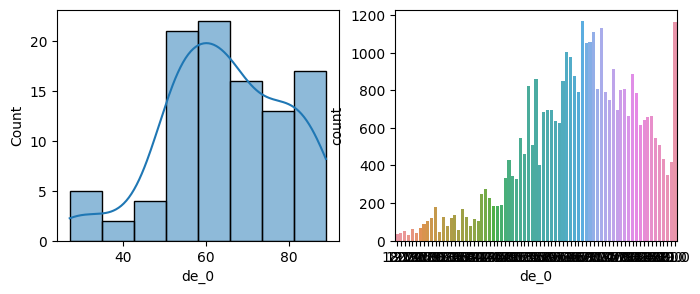

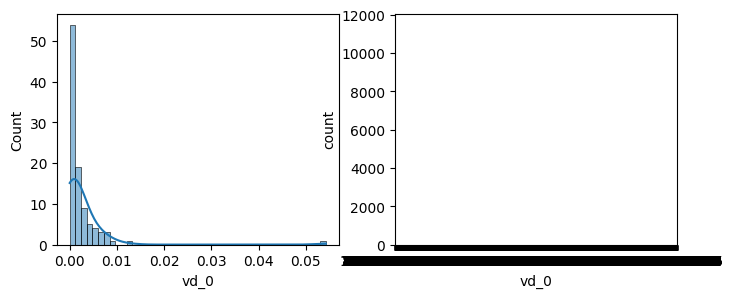

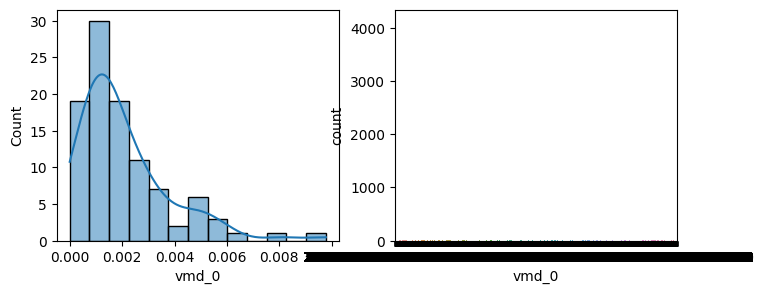

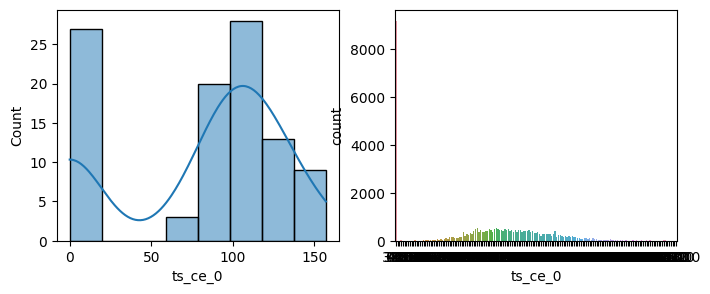

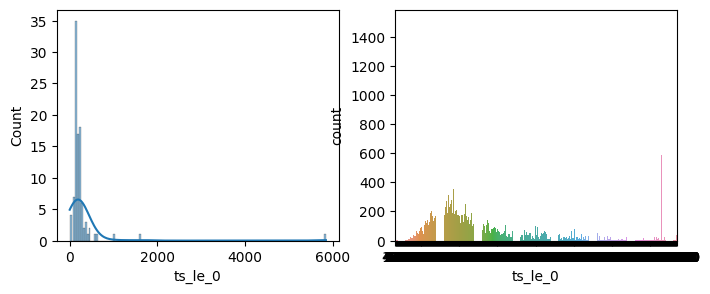

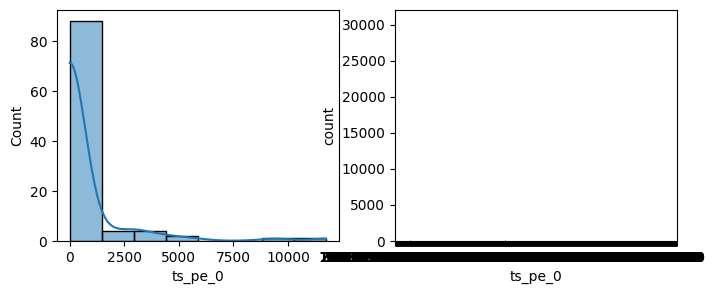

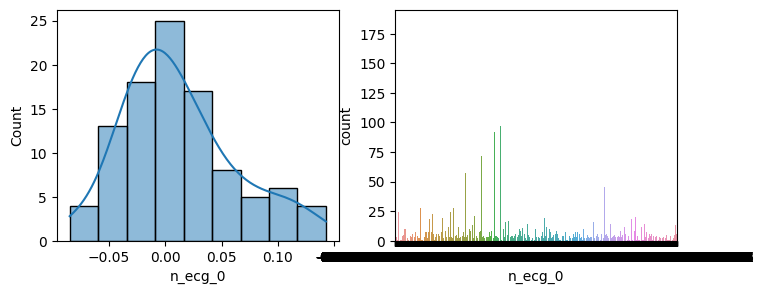

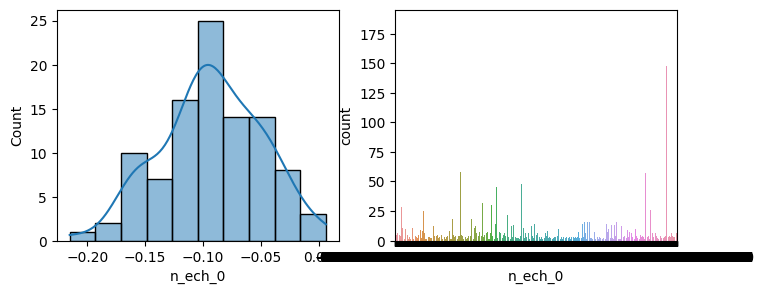

In [28]:
plot_dist(x_train, sample_size=100)

In [30]:
# x_train.describe()

In [31]:
x_train.mean()

de_0         65.650473
de_1          0.587115
de_2          5.889157
de_3          1.384592
de_4          0.901604
               ...    
n_ech_763    -0.226073
n_ech_764     0.003631
n_ech_765     0.985206
n_ech_766    -0.250974
n_ech_767     0.999796
Length: 4041, dtype: float64

In [32]:
x_train.std()

de_0         14.983756
de_1          0.492359
de_2          1.971558
de_3          0.976339
de_4          0.297853
               ...    
n_ech_763     0.069877
n_ech_764     0.039236
n_ech_765     0.029674
n_ech_766     0.067106
n_ech_767     0.000143
Length: 4041, dtype: float64

In [33]:
norm_df = (x_train - x_train.mean()) / x_train.std()

In [34]:
# norm_df.describe()

In [35]:
x_train.mean() - norm_df.mean()

de_0         65.650473
de_1          0.587115
de_2          5.889157
de_3          1.384592
de_4          0.901604
               ...    
n_ech_763    -0.226073
n_ech_764     0.003631
n_ech_765     0.985206
n_ech_766    -0.250974
n_ech_767     0.999796
Length: 4041, dtype: float64

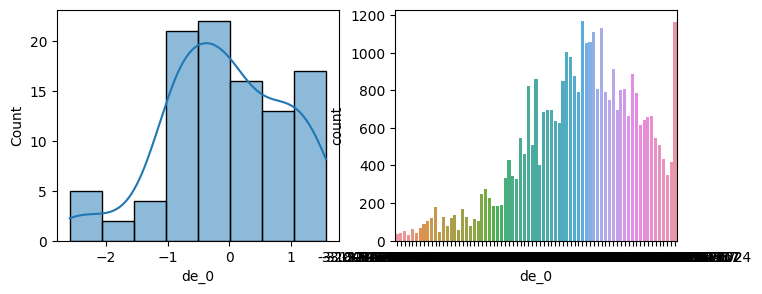

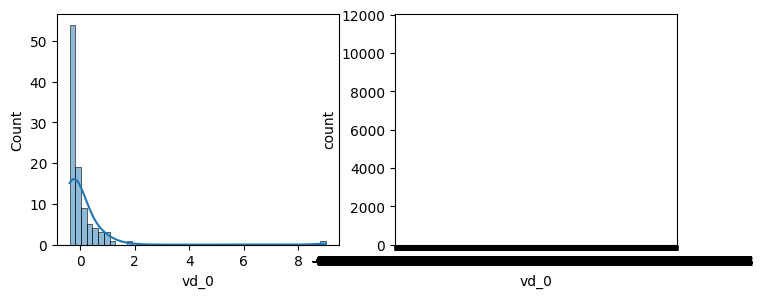

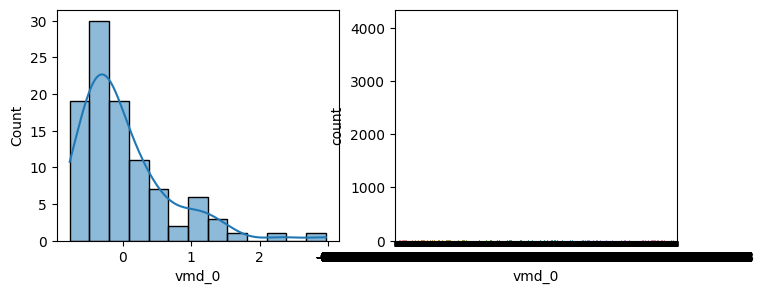

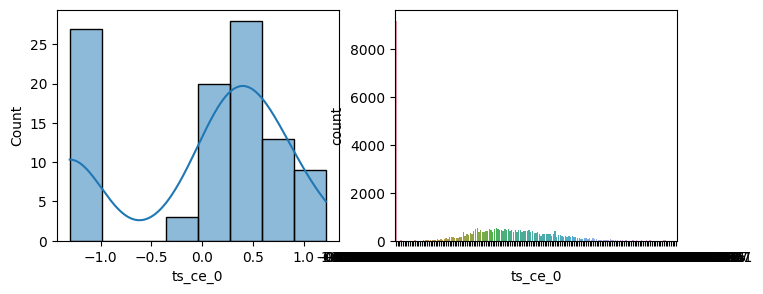

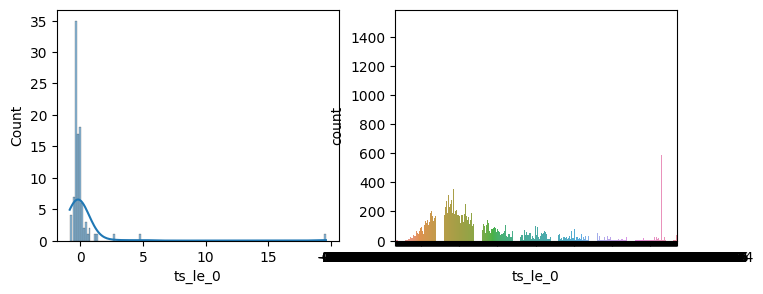

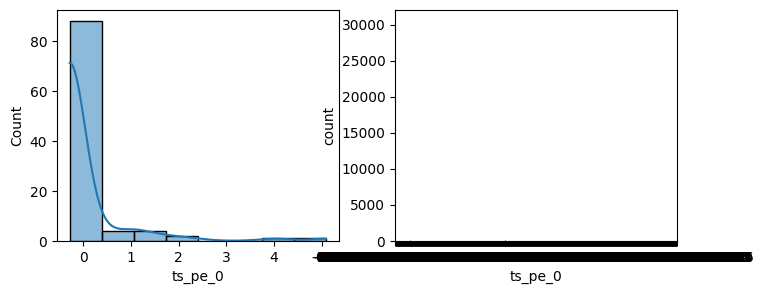

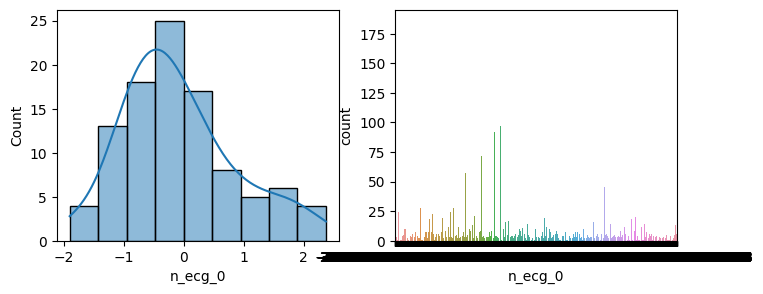

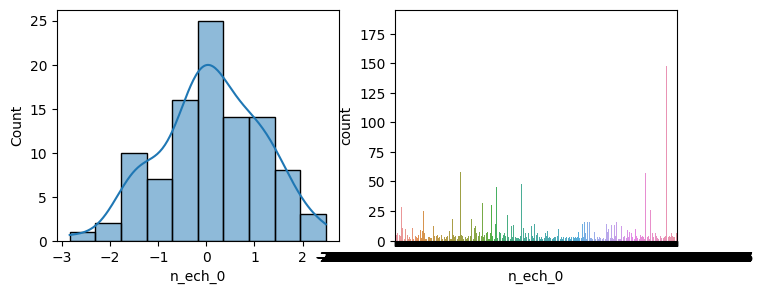

In [36]:
plot_dist(norm_df, sample_size=100)

In [37]:
def normalize_splits(train, val, test):
    '''Normalize the splits'''
    train_mean = train.mean()
    train_std = train.std()
    train_norm = (train - train_mean) / train_std
    val_norm = (val - train_mean) / train_std
    test_norm = (test - train_mean) / train_std
    return train_norm, val_norm, test_norm

In [38]:
x_train, x_val, x_test = normalize_splits(x_train, x_val, x_test)

## Write to Disk

In [39]:
print("Confirming shapes of train, val, test splits:")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")


Confirming shapes of train, val, test splits:
x_train: (35591, 4041), y_train: (35591, 13)
x_val: (4886, 4041), y_val: (4886, 13)
x_test: (4573, 4041), y_test: (4573, 13)


In [40]:
print(y_train.columns)

Index(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
       'Pneumothorax'],
      dtype='object')


In [41]:
# Write to files into a new folder called splits
if not os.path.exists(f'{datapath}/splits'):
    os.makedirs(f'{datapath}/splits')
    
x_train.to_csv(f'{datapath}/splits/x_train.csv', index=False)
y_train.to_csv(f'{datapath}/splits/y_train.csv', index=False)

x_val.to_csv(f'{datapath}/splits/x_val.csv', index=False)
y_val.to_csv(f'{datapath}/splits/y_val.csv', index=False)

x_test.to_csv(f'{datapath}/splits/x_test.csv', index=False)
y_test.to_csv(f'{datapath}/splits/y_test.csv', index=False)

# Read splits

In [42]:
x_train = pd.read_csv(f'{datapath}/splits/x_train.csv')
y_train = pd.read_csv(f'{datapath}/splits/y_train.csv')

x_val = pd.read_csv(f'{datapath}/splits/x_val.csv')
y_val = pd.read_csv(f'{datapath}/splits/y_val.csv')

x_test = pd.read_csv(f'{datapath}/splits/x_test.csv')
y_test = pd.read_csv(f'{datapath}/splits/y_test.csv')

In [43]:
len(x_train), len(x_val), len(x_test)

(35591, 4886, 4573)

In [44]:
x_train.head(5)

,de_0,de_1,de_2,de_3,de_4,de_5,vd_0,vd_1,vd_2,vd_3,...,n_ech_758,n_ech_759,n_ech_760,n_ech_761,n_ech_762,n_ech_763,n_ech_764,n_ech_765,n_ech_766,n_ech_767
0,-0.844279,-1.192451,0.563434,0.630323,0.33035,-0.612963,-0.349168,1.526995,1.712011,-0.280812,...,0.252892,-0.240060,-0.646241,0.073482,-1.082918,-0.126508,-0.464556,0.402132,-1.113065,0.559119
1,-0.844279,-1.192451,-0.958206,0.630323,0.33035,-0.612963,-0.381198,-0.860359,2.236501,-0.143257,...,-1.144516,0.036303,1.658378,-0.935807,0.509747,-0.880069,1.415723,0.124702,-1.333540,0.003131
2,0.223544,0.838585,0.563434,-0.393912,0.33035,-0.612963,-0.381198,-0.964236,-0.017702,0.566660,...,0.991859,-1.347739,-0.340547,0.018985,1.067037,0.161201,-0.591375,0.356024,-0.137333,0.173086
3,-0.844279,-1.192451,0.563434,0.630323,0.33035,-0.612963,0.148463,1.215924,1.296045,-0.448268,...,0.252892,-0.240060,-0.646241,0.073482,-1.082918,-0.126508,-0.464556,0.402132,-1.113065,0.559119
4,-0.844279,-1.192451,0.563434,0.630323,0.33035,-0.612963,-0.381198,0.241868,0.264737,0.767094,...,0.252892,-0.240060,-0.646241,0.073482,-1.082918,-0.126508,-0.464556,0.402132,-1.113065,0.559119


In [ ]:
# before norming
old_x_train.head(5)

,de_0,de_1,de_2,de_3,de_4,de_5,vd_0,vd_1,vd_2,vd_3,...,n_ech_758,n_ech_759,n_ech_760,n_ech_761,n_ech_762,n_ech_763,n_ech_764,n_ech_765,n_ech_766,n_ech_767
0,53.0,0,7,2,1,1,0.000185,0.120269,0.427006,0.004908,...,0.043556,-0.141896,0.041412,-0.061159,-0.126256,-0.234913,-0.014596,0.997139,-0.325668,0.999876
1,53.0,0,4,2,1,1,0.000000,0.024619,0.479709,0.006753,...,-0.035256,-0.128450,0.231663,-0.123437,-0.073406,-0.287570,0.059177,0.988906,-0.340464,0.999796
2,69.0,1,7,1,1,1,0.000000,0.020457,0.253198,0.016274,...,0.085233,-0.195788,0.066648,-0.064522,-0.054913,-0.214809,-0.019572,0.995771,-0.260190,0.999820
3,53.0,0,7,2,1,1,0.003060,0.107806,0.385208,0.002662,...,0.043556,-0.141896,0.041412,-0.061159,-0.126256,-0.234913,-0.014596,0.997139,-0.325668,0.999876
4,53.0,0,7,2,1,1,0.000000,0.068780,0.281578,0.018962,...,0.043556,-0.141896,0.041412,-0.061159,-0.126256,-0.234913,-0.014596,0.997139,-0.325668,0.999876


In [45]:
y_train.head(5)

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax
0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0
2,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,-1.0,NaN


In [ ]:
y_train.head(5)

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax
0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0
2,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,-1.0,NaN


## Label Counts

### Before Fixing `-1`s

In [ ]:
for col in y_train.columns:
    print(f"{col} --> {y_train[col].unique()}")

Atelectasis --> [ 1. nan  0. -1.]
Cardiomegaly --> [ 1. nan  0. -1.]
Consolidation --> [nan  1. -1.  0.]
Edema --> [ 1. nan  0. -1.]
Enlarged Cardiomediastinum --> [nan  1.  0. -1.]
Fracture --> [nan  1. -1.  0.]
Lung Lesion --> [nan  1. -1.  0.]
Lung Opacity --> [ 1. nan -1.  0.]
No Finding --> [nan  1.]
Pleural Effusion --> [nan  0.  1. -1.]
Pleural Other --> [nan  1. -1.  0.]
Pneumonia --> [nan -1.  0.  1.]
Pneumothorax --> [nan  0.  1. -1.]


In [ ]:
y_train.sum(axis=0).to_dict()

{'Atelectasis': 10010.0,
 'Cardiomegaly': 10869.0,
 'Consolidation': 2003.0,
 'Edema': 5524.0,
 'Enlarged Cardiomediastinum': -922.0,
 'Fracture': 417.0,
 'Lung Lesion': 571.0,
 'Lung Opacity': 10080.0,
 'No Finding': 4123.0,
 'Pleural Effusion': 15409.0,
 'Pleural Other': 197.0,
 'Pneumonia': 300.0,
 'Pneumothorax': 2054.0}

### After Fixing

In [ ]:
new_y_train = y_train.fillna(0).replace(-1, 0)
for col in new_y_train.columns:
    print(f"{col} --> {new_y_train[col].unique()}")

Atelectasis --> [1. 0.]
Cardiomegaly --> [1. 0.]
Consolidation --> [0. 1.]
Edema --> [1. 0.]
Enlarged Cardiomediastinum --> [0. 1.]
Fracture --> [0. 1.]
Lung Lesion --> [0. 1.]
Lung Opacity --> [1. 0.]
No Finding --> [0. 1.]
Pleural Effusion --> [0. 1.]
Pleural Other --> [0. 1.]
Pneumonia --> [0. 1.]
Pneumothorax --> [0. 1.]


In [ ]:
new_y_train.sum(axis=0).to_dict()

{'Atelectasis': 11720.0,
 'Cardiomegaly': 12446.0,
 'Consolidation': 2882.0,
 'Edema': 8499.0,
 'Enlarged Cardiomediastinum': 1878.0,
 'Fracture': 442.0,
 'Lung Lesion': 670.0,
 'Lung Opacity': 10810.0,
 'No Finding': 4123.0,
 'Pleural Effusion': 16488.0,
 'Pleural Other': 260.0,
 'Pneumonia': 3034.0,
 'Pneumothorax': 2366.0}